## **EDA and Preprocessing**
- WNBA Shots Dataset
- Removed unhelpful attributes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
import numpy as np
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('wnba-shots-2021.csv')

In [2]:
data.head(1)

,game_id,game_play_number,desc,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_team_name,away_team_name,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining
0,401391650,4,Shatori Walker-Kimbrough blocks Destanni Hende...,Jump Shot,False,0,37,9,Indiana,Washington,Indiana,0,0,1,571,2371


### **1. Removing unnecessary attributes**
- The tasks / questions we need to answer are:
    - Classification model to predict the shot outcome based on the coordinates of the shot
    - Visualization displaying the joint frequency of shot locations / team / shot type
    - Glass-Box model
    - Black-Box model
    - Pre and Post Modeling XAI
- We do not want attributes that do not give us information for the tasks such as:
    - game_id, game_play_number, desc, home_team_name, away_team_name
- We consider these attributes irrelevant also for XAI tasks


In [3]:
# Removing attributes
columns_to_remove = ['game_id', 'game_play_number', 'desc', 'home_team_name', 'away_team_name']
data = data.drop(columns=columns_to_remove)
data.head(1)

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining
0,Jump Shot,False,0,37,9,Indiana,0,0,1,571,2371


### **2. Creating new features**
- Adjuster hoop to be at coordinates 0,0
- Created distance attribute
- Grouped shot_types

In [4]:
# Adjust coordinates to center the hoop at 0,0
data['coordinate_x'] = data['coordinate_x'] - 25
data['coordinate_y'] = data['coordinate_y']

# Euclidean distance
data['distance'] = np.sqrt(data['coordinate_x']**2 + data['coordinate_y']**2)

data.head(1)

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,distance
0,Jump Shot,False,0,12,9,Indiana,0,0,1,571,2371,15.0


In [5]:
# Define shot groups
shot_groups = {
    'Free Throw': [
        'Free Throw - 1 of 1', 'Free Throw - 1 of 2', 'Free Throw - 1 of 3',
        'Free Throw - 2 of 2', 'Free Throw - 2 of 3', 'Free Throw - 3 of 3',
        'Free Throw - Clear Path 1 of 2', 'Free Throw - Clear Path 2 of 2',
        'Free Throw - Flagrant 1 of 1', 'Free Throw - Flagrant 1 of 2', 
        'Free Throw - Flagrant 1 of 3', 'Free Throw - Flagrant 2 of 2',
        'Free Throw - Flagrant 2 of 3', 'Free Throw - Flagrant 3 of 3',
        'Free Throw - Technical'
    ],
    'Jump Shot': [
        'Jump Shot', 'Pullup Jump Shot', 'Fade Away Jump Shot', 'Step Back Jump Shot',
        'Turnaround Jump Shot', 'Turnaround Fade Away Jump Shot',
        'Turnaround Fadeaway Bank Jump Shot', 'Turnaround Bank Jump Shot',
        'Step Back Bank Jump Shot', 'Pullup Bank Jump Shot', 'Driving Jump Shot Bank'
    ],
    'Layup': [
        'Layup Shot', 'Driving Layup Shot', 'Running Layup Shot', 'Reverse Layup Shot',
        'Driving Finger Roll Layup', 'Running Finger Roll Layup', 'Cutting Finger Roll Layup Shot',
        'Layup Running Reverse', 'Layup Driving Reverse', 'Layup Shot Putback', 
        'Cutting Layup Shot', 'Alley Oop Layup Shot', 'Running Alley Oop Layup Shot'
    ],
    'Dunk': [
        'Dunk Shot', 'Driving Dunk Shot', 'Running Dunk Shot', 'Alley Oop Dunk Shot'
    ],
    'Hook Shot': [
        'Hook Shot', 'Driving Hook Shot', 'Turnaround Hook Shot', 'Hook Driving Bank',
        'Hook Shot Bank', 'Hook Turnaround Bank'
    ],
    'Tip Shot': ['Tip Shot'],
    'Other': ['No Shot (Default Shot)']
}

# Apply the grouping
shot_type_to_group = {shot: group for group, shots in shot_groups.items() for shot in shots}
data['shot_group'] = data['shot_type'].map(shot_type_to_group)
data.head(1)

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,distance,shot_group
0,Jump Shot,False,0,12,9,Indiana,0,0,1,571,2371,15.0,Jump Shot


### **3. Encoding non numarical features**
- Used Sklearn LabelEncoder
- Encoded:
    - shot_type
    - shooting_team
    - shot_group

In [6]:
# Encode features
label_encoder = LabelEncoder()
data['shooting_team_encoded'] = label_encoder.fit_transform(data['shooting_team'])
data['shot_type_encoded'] = label_encoder.fit_transform(data['shot_type'])
data['shot_group_encoded'] = label_encoder.fit_transform(data['shot_group'])
data.head(1)

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,distance,shot_group,shooting_team_encoded,shot_type_encoded,shot_group_encoded
0,Jump Shot,False,0,12,9,Indiana,0,0,1,571,2371,15.0,Jump Shot,4,34,3


In [7]:
# Save the dataset
data.to_csv('wnba_clean.csv', index=False)

### **4. EDA**
- Number of shots per each shot group
- Successn rate per shot group
- Shot location heatmap

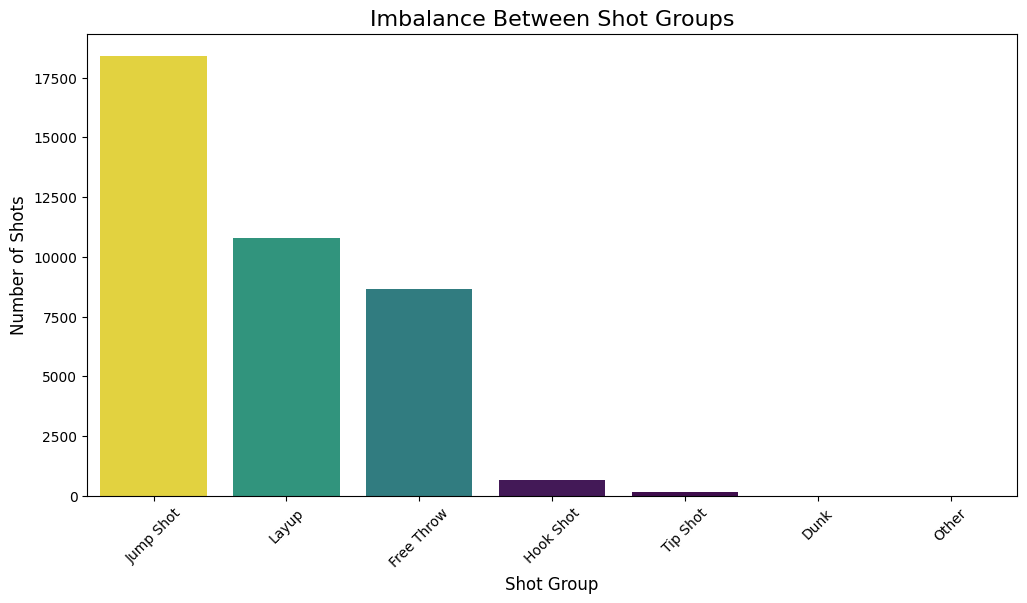

In [8]:
# Count the number of shots in each shot group
group_counts = data['shot_group'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis", hue=group_counts, legend=False)
plt.title('Imbalance Between Shot Groups', fontsize=16)
plt.xlabel('Shot Group', fontsize=12)
plt.ylabel('Number of Shots', fontsize=12)
plt.xticks(rotation=45)
plt.show()

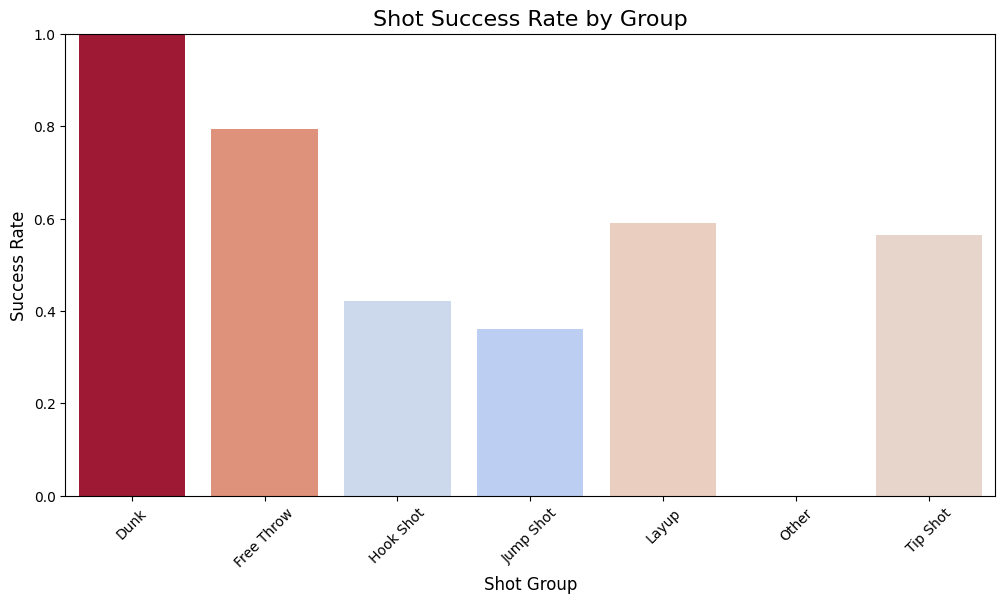

In [9]:
# Success rate for each shot group
group_success_rates = data.groupby('shot_group')['made_shot'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=group_success_rates.index, y=group_success_rates.values, palette="coolwarm", hue=group_success_rates, legend=False)
plt.title('Shot Success Rate by Group', fontsize=16)
plt.xlabel('Shot Group', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [ ]:
# Shot location heatmap
def draw_court(color='black', lw=2):
    plt.figure(figsize=(12, 11))
    ax = plt.gca()
    hoop = Circle((0, 0), radius=0.75, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-3, -1), 6, -0.1, linewidth=lw, color=color)
    outer_box = Rectangle((-8, -4.8), 16, 19, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-6, -4.8), 12, 19, linewidth=lw, color=color, fill=False)
    free_throw_top = Arc((0, 14.6), 12, 12, theta1=0, theta2=180, linewidth=lw, color=color)
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color)
    three_point_arc = Arc((0, 0), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw, color=color)
    corner_three_a = Rectangle((-22, 0), 0, 14, linewidth=lw, color=color)
    corner_three_b = Rectangle((22, 0), 0, 14, linewidth=lw, color=color)
    court_elements = [
        hoop, backboard, outer_box, inner_box, free_throw_top, restricted,
        three_point_arc, corner_three_a, corner_three_b
    ]

    for element in court_elements:
        ax.add_patch(element)

    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 47)
    ax.set_aspect(1)

    return ax

# Draw the basketball court
draw_court()

In [ ]:
# Normalize the heatmap values to get relative densities
relative_heatmap = heatmap / np.max(heatmap)  # Normalize by the max density

# Plot the relative threat heatmap
plt.figure(figsize=(12, 11))
ax = plt.gca()

# Draw the basketball court
draw_court(ax)

# Overlay the normalized heatmap
c = ax.pcolormesh(xedges, yedges, relative_heatmap, cmap='Reds', alpha=0.7)

# Add color bar
plt.colorbar(c, ax=ax, label='Relative Threat (Normalized)')

# Adjust axis limits
ax.set_xlim(-25, 25)
ax.set_ylim(0, 47)

# Titles and labels
ax.set_title('WNBA Shot Frequency Heatmap', fontsize=16)
ax.set_xlabel('Horizontal Distance (ft)')
ax.set_ylabel('Vertical Distance (ft)')
plt.show()


In [ ]:
# Apply logarithmic transformation to reduce variance
log_heatmap = np.log1p(heatmap)  # log(1 + x) to handle zero values

# Normalize the log-transformed heatmap
log_heatmap_normalized = log_heatmap / np.max(log_heatmap)  # Scale between 0 and 1

# Plot the log-transformed heatmap
plt.figure(figsize=(12, 11))
ax = plt.gca()

# Draw the basketball court
draw_court(ax)

# Overlay the log-transformed heatmap
c = ax.pcolormesh(xedges, yedges, log_heatmap_normalized, cmap='Reds', alpha=0.7)

# Add color bar
plt.colorbar(c, ax=ax, label='Relative Threat (Log-Scaled)')

# Adjust axis limits
ax.set_xlim(-25, 25)
ax.set_ylim(0, 47)

# Titles and labels
ax.set_title('WNBA Shot Frequency Heatmap (Log-Scaled)', fontsize=16)
ax.set_xlabel('Horizontal Distance (ft)')
ax.set_ylabel('Vertical Distance (ft)')
plt.show()
